# Main characteristics 
- normalization of datasets + hot encoding of labels (classes)
- Initilization with Xavier Normal
- No Data Augmentation
- 2 conv layers (32 filters, 3x3), Leakyrelu activation, dropout 50%, BatchNormalization
- 2 conv layers (64 filters, 3x3), Leakyrelu activation, dropout 50%, BatchNormalization
- 2 conv layers (128 filters, 3x3), Leakyrelu activation, dropout 50%, BatchNormalization
- 4 dense hidden layers (2048, 1024, 512, 128, neurones), dropout 50%
- softmax
- loss="Categorical_crossentropy", optimizer="adam", LR=0.0005 -- ACCURACY (compare with v2.10 at 88.2%) 

In [13]:
# Load notebook extension
%load_ext tensorboard

# Import required packages
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, LeakyReLU, Activation
from tensorflow.keras.initializers import GlorotUniform,  GlorotNormal, RandomNormal, RandomUniform, LecunNormal, LecunUniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from packaging import version

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


X_train_raw: (50000, 32, 32, 3)  as  uint8
y_train: (50000, 1)  as  uint8
X_test_raw:  (10000, 32, 32, 3)  as  uint8
y_test:  (10000, 1)  as  uint8


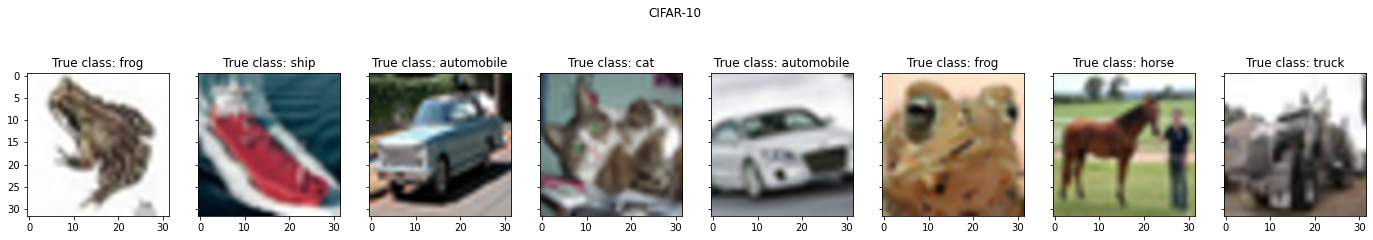

In [14]:
# Load CIFAR-10 dataset & check data dimension
# Ref: Homepage: https://www.cs.toronto.edu/~kriz/cifar.html

(X_train_raw, y_train), (X_test_raw, y_test) = tf.keras.datasets.cifar10.load_data() 

print("X_train_raw:",X_train_raw.shape, " as ", X_train_raw.dtype)
print("y_train:",y_train.shape, " as ", y_train.dtype)
print("X_test_raw: ",X_test_raw.shape, " as ", X_test_raw.dtype)
print("y_test: ",y_test.shape, " as ", y_test.dtype)

# Set training and test datasets, define classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
N_classes = len(class_names)

# Plot a couple of pictures for fun
Npics=8
fig, ax = plt.subplots(nrows=1, ncols=Npics, figsize=(Npics*3,4), sharey=True)
fig.suptitle('CIFAR-10')
for i in range(Npics):
  rnd = np.random.randint(1000)
  ax[i].imshow(X_train_raw[rnd,:,:,:], interpolation='spline16')
  ax[i].set_title (str("True class: "+class_names[y_train[rnd][0]]))


In [15]:
### Normalization

X_train = X_train_raw.astype(np.float32) /255.0
X_test = X_test_raw.astype(np.float32) / 255.0

# OR

### Standardization over whole dataset but each RGB channel independently")

# X_train_mean = np.mean(X_train_raw.astype(np.float32), axis=(0,1,2))
# X_train_std = np.std(X_train_raw.astype(np.float32), axis=(0,1,2))
# X_train = (X_train_raw.astype(np.float32) - X_train_mean) / X_train_std
# X_test = (X_test_raw.astype(np.float32) - X_train_mean) / X_train_std

print("X_train:",X_train.shape, " as ", X_train.dtype)
print("X_test: ",X_test.shape, " as ", X_train.dtype)
print()

print("== 1st image ==\n RGB channel average:",X_train[0,:,:,:].mean(axis=(0,1)))
print(" RGB channel min:",X_train[0,:,:,:].min(axis=(0,1)))
print(" RGB channel max:",X_train[0,:,:,:].max(axis=(0,1)))

X_train: (50000, 32, 32, 3)  as  float32
X_test:  (10000, 32, 32, 3)  as  float32

== 1st image ==
 RGB channel average: [0.5537454  0.41215533 0.25112593]
 RGB channel min: [0. 0. 0.]
 RGB channel max: [1.         0.99215686 0.92156863]


In [16]:
# Hot encoding of labels (not strictly necessary, depends on selected loss function)

y_train_cat = to_categorical (y_train).astype(np.uint8)
y_test_cat = to_categorical (y_test).astype(np.uint8)

print("y_train_cat:",y_train_cat.shape, " as ", y_train_cat.dtype)
print("y_test_cat: ",y_test_cat.shape, " as ", y_test_cat.dtype)

print(y_train_cat[0])


y_train_cat: (50000, 10)  as  uint8
y_test_cat:  (10000, 10)  as  uint8
[0 0 0 0 0 0 1 0 0 0]


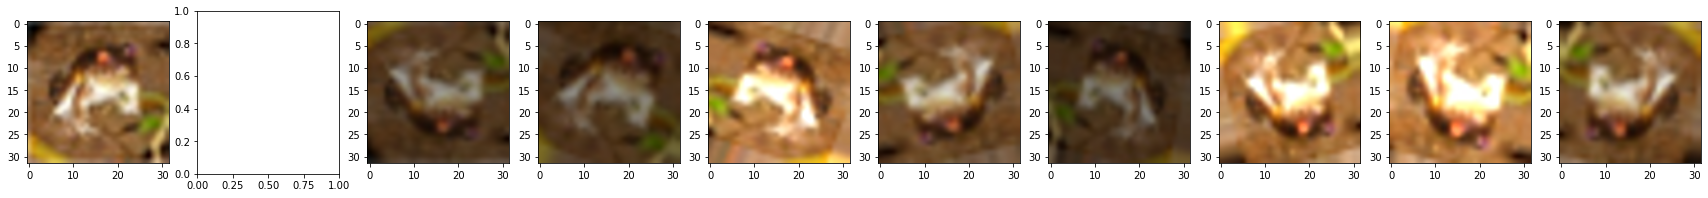

In [17]:
# Dataset augmentation 

datagen = ImageDataGenerator(
            rescale = 1./255,
            # featurewise_center=True, #### average done on whole dataset
            # featurewise_std_normalization=True,             
            # samplewise_center=True,  #### average done on each image
            # samplewise_std_normalization=True,    
            # zca_whitening=True, 
            # zca_epsilon=2, 
            rotation_range=20,
            zoom_range=[0.9, 1.1],
            # width_shift_range=0.1,
            # height_shift_range=0.1,
            fill_mode="nearest",  # "reflect", "nearest", wrap, constant
            # cval=0.0,
            # channel_shift_range=32, 
            # shear_range=15,
            brightness_range=[0.5,1.5],
            horizontal_flip=True, 
            vertical_flip=True, 
            # preprocessing_function=None, 
            # data_format='channels_last', 
            # validation_split=0.2, 
            # dtype='float32'
            )
            
datagen.fit(X_train_raw)


def show_augmentation(datagen, X, n_pics=5):
    rnd = np.random.randint(X.shape[0])
    img_iterator = datagen.flow(X[rnd].reshape(1, 32, 32, 3), batch_size=1)

    fig, ax = plt.subplots(nrows=1, ncols=n_pics+2, figsize=((n_pics+2)*3, 3))
    ax[0].imshow(X[rnd].reshape(32,32,3), interpolation='spline16') 
    # ax[1].axis('off')
    for i in range(n_pics):
        # ax[i+2].axis('off')
        img = img_iterator.next().reshape(32,32,3)
        # ax[i+2].imshow(img.astype('uint8')) ### use when no rescaling defined in ImageDataGenerator
        ax[i+2].imshow(img, interpolation='spline16') 

show_augmentation(datagen, X_train_raw[0:5], 8) # Must be passed dataset used during Generator fit 


# X = X_train_raw[10]
# gen = datagen.flow(X.reshape(1, 32, 32, 3),  batch_size=1)

# print("== orignal image ==\n RGB channel average:",X[:,:,:].mean(axis=(0,1)))
# print(" RGB channel min:",X[:,:,:].min(axis=(0,1)))
# print(" RGB channel max:",X[:,:,:].max(axis=(0,1)))
# print(X[:,0,0])

# Xnorm = X_train[10]
# print("== Normalized image ==\n RGB channel average:",Xnorm[:,:,:].mean(axis=(0,1)))
# print(" RGB channel min:",Xnorm[:,:,:].min(axis=(0,1)))
# print(" RGB channel max:",Xnorm[:,:,:].max(axis=(0,1)))
# print(Xnorm[:,0,0])

# img_aug = gen.next().reshape(32,32,3)
# print("== Aug image ==\n RGB channel average:",img_aug[:,:,:].mean(axis=(0,1)))
# print(" RGB channel min:",img_aug[:,:,:].min(axis=(0,1)))
# print(" RGB channel max:",img_aug[:,:,:].max(axis=(0,1)))
# print(img_aug[:,0,0])

In [18]:
def plot_evaluation (history_pd):
    Nfigs = int(len(history_pd.columns)/2)
    fig, ax = plt.subplots(nrows=1, ncols=Nfigs, figsize=(Nfigs*5,3))
    fig.suptitle('CIFAR-10 evaluation')

    for i in range(Nfigs):
        history_pd.iloc[:,i].plot(ax=ax[i], label='Training ') 
        history_pd.iloc[:,i+Nfigs].plot(ax=ax[i], label='Validation ')
        ax[i].set_title(history_pd.columns[i])
        ax[i].legend()
        ax[i].grid(True)
        ax[i].set_xlabel('epochs')

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9


In [19]:
# seed = 100
def build_VGG10_model (myInitializer="glorot_uniform", myLoss="categorical_crossentropy", myOptimizer="adam", myMetrics=["accuracy"], myActivation='relu', myDropout_Conv=0.25, myDropout_Dense=0.25):

    model = Sequential()

    model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Conv2D(filters=128,kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Flatten())

    model.add(Dense(2048, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(1024, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(512, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(128, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

    return model
        

In [21]:
#### RUN PARAMETERS
batch_size = 128
N_epochs = 300
N_steps = X_train.shape[0] // batch_size

#### INITIALIZERS
myInitializer = GlorotNormal()
# myInitializer = GlorotUniform()
# myInitializer = LecunNormal()
# myInitializer = LecunUniform()
# myInitializer = RandomNormal()

#### OPTIMIZERS
# lr_ExpDecay = ExponentialDecay(initial_learning_rate = 0.01, decay_steps = N_steps * 15, decay_rate = 0.1, staircase=True)
# myOptimizer = SGD(learning_rate=0.001)
# myOptimizer = SGD(learning_rate=lr_ExpDecay, decay=1e-6, momentum=0.9, nesterov=True)
# myOptimizer = RMSprop(learning_rate=0.01, decay=1e-06)
myOptimizer = Adam(learning_rate=0.0005, epsilon=1e-08)
# myOptimizer = Adam(learning_rate=lr_ExpDecay, epsilon=1e-08)

#### LOSSES
# myLoss = "sparse_categorical_crossentropy" 
myLoss = "categorical_crossentropy" 
# myLoss = "mse"

#### METRICS
myMetrics = ["accuracy"] #,Precision(name='precision'), Recall(name='recall')]

#### ACTIVATION
# myActivation = 'relu'
myActivation = LeakyReLU()

#### CALLBACKS
logdir = "logs/scalars/" + "cifar10-v2.13"  # datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_CB = TensorBoard(log_dir=logdir, histogram_freq=1)
# early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=4)
# LR_scheduler = LearningRateScheduler(lr_schedule)
# RonP = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
myCallbacks = [tensorboard_CB] 


##### BUILD MODEL
model = build_VGG10_model (myInitializer, myLoss, myOptimizer, myMetrics, myActivation, myDropout_Conv=0.5, myDropout_Dense=0.5)
# model.summary()

# %tensorboard --logdir logs/scalars

Running 300 Epochs (batch size 128) with 390steps/epoch
Epoch 1/300
390/390 [==============================] - 14s 31ms/step - loss: 2.2947 - accuracy: 0.2314 - val_loss: 3.8016 - val_accuracy: 0.1297
Epoch 2/300
390/390 [==============================] - 8s 21ms/step - loss: 1.5695 - accuracy: 0.4253 - val_loss: 1.7014 - val_accuracy: 0.4106
Epoch 3/300
390/390 [==============================] - 8s 21ms/step - loss: 1.3532 - accuracy: 0.5067 - val_loss: 1.2176 - val_accuracy: 0.5674
Epoch 4/300
390/390 [==============================] - 8s 21ms/step - loss: 1.2105 - accuracy: 0.5682 - val_loss: 1.6815 - val_accuracy: 0.4644
Epoch 5/300
390/390 [==============================] - 9s 22ms/step - loss: 1.1184 - accuracy: 0.6040 - val_loss: 0.9161 - val_accuracy: 0.6735
Epoch 6/300
390/390 [==============================] - 8s 21ms/step - loss: 1.0384 - accuracy: 0.6342 - val_loss: 0.9754 - val_accuracy: 0.6565
Epoch 7/300
390/390 [==============================] - 9s 22ms/step - loss: 0.9

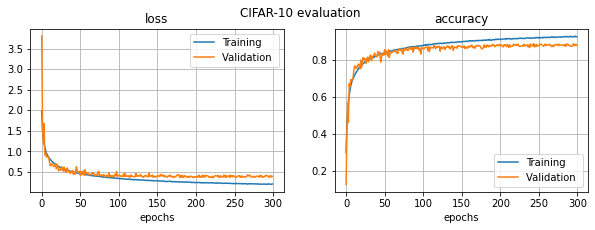

In [22]:
print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

history = model.fit(
                    X_train, y_train_cat, 
                    # X_train_aug, y_train_cat_aug,
                    # training_generator,
                    batch_size = batch_size,
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    shuffle=True, 
                    validation_data=(X_test, y_test_cat), 
                    # validation_data=validation_generator,
                    callbacks = myCallbacks,
                    verbose=1,
                    )

pd_history = pd.DataFrame(history.history) 
# pd_history_old = pd_history
# pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)